In [0]:
!pip install utils

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from torchvision.models import *
import pretrainedmodels

from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta

from utils import *
import sys

In [0]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=23d569f18147f09f01e5970a34031fedbbdc9b8a777f9cbc407ef92f05575654
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [0]:
from efficientnet_pytorch import EfficientNet

In [0]:
!pip install efficientnet_pytorch

In [0]:
cd 'drive/My Drive/Satellite data'

/content/drive/My Drive/Satellite data


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

In [0]:
np.random.seed(2)

In [0]:
data = ImageDataBunch.from_folder('/content/drive/My Drive/Satellite data/data_processed/train',train='', test = '/content/drive/My Drive/Satellite data/data_processed/test',valid_pct = 0.2,  ds_tfms=get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.), 
                              size=256, bs=32).normalize(imagenet_stats)

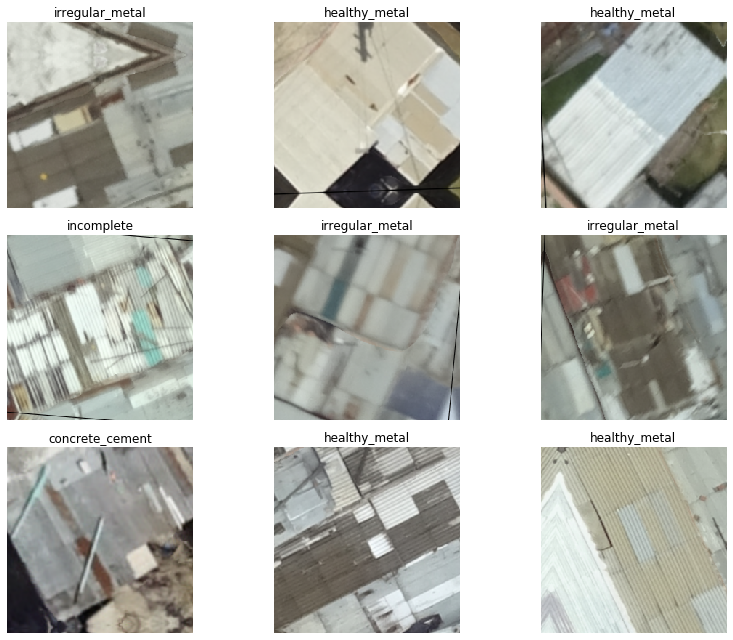

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=data.c)
model._fc = nn.Linear(in_features=2560, out_features=5, bias=True)

Loaded pretrained weights for efficientnet-b7


In [0]:
learn = Learner(data, model, metrics=[error_rate]).mixup().to_fp16()

In [0]:
#learn = cnn_learner(data, models.resnet152, metrics=[error_rate]).mixup().to_fp16()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 86.0MB/s]


In [0]:
#preds,y = learn.TTA(ds_type=DatasetType.Test)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff44862f8d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff44862f8d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff44862f8d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ff44862f8d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/usr/local/l

In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 3.31E-05


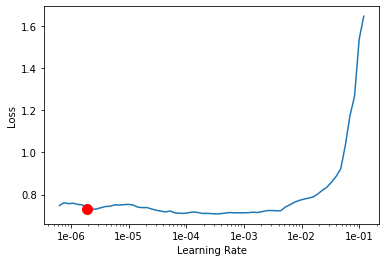

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


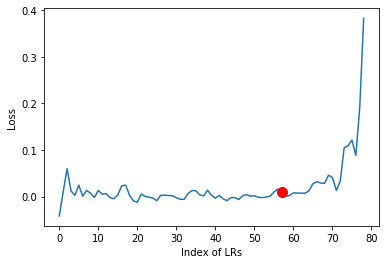

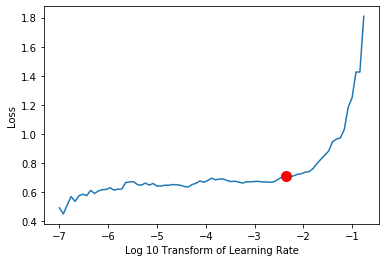

0.004365158322401656


In [0]:
lr1  = find_appropriate_lr(learn, plot=True)
print(lr1)

In [0]:
#lr  = find_appropriate_lr(learn)/10.0
learn.fit_one_cycle(20, max_lr =slice(1e-05) ,callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,time
0,0.731583,0.517469,0.196032,07:36
1,0.701056,0.493442,0.189307,07:35
2,0.672076,0.466191,0.179220,07:35
3,0.662682,0.447627,0.170814,07:36
4,0.650110,0.433745,0.167787,07:35
5,0.641102,0.425859,0.167451,07:36
6,0.647756,0.417584,0.162744,07:35
7,0.661940,0.413947,0.159718,07:35
8,0.617876,0.412200,0.160390,07:35
9,0.642429,0.411943,0.159045,07:35


Better model found at epoch 0 with valid_loss value: 0.5174691677093506.
Better model found at epoch 1 with valid_loss value: 0.4934423863887787.
Better model found at epoch 2 with valid_loss value: 0.4661911725997925.
Better model found at epoch 3 with valid_loss value: 0.4476274847984314.
Better model found at epoch 4 with valid_loss value: 0.43374526500701904.
Better model found at epoch 5 with valid_loss value: 0.4258590340614319.
Better model found at epoch 6 with valid_loss value: 0.4175841212272644.
Better model found at epoch 7 with valid_loss value: 0.41394728422164917.
Better model found at epoch 8 with valid_loss value: 0.41220033168792725.
Better model found at epoch 9 with valid_loss value: 0.4119434952735901.
Better model found at epoch 10 with valid_loss value: 0.41108688712120056.
Better model found at epoch 11 with valid_loss value: 0.4065800905227661.
Better model found at epoch 12 with valid_loss value: 0.4044201672077179.
Better model found at epoch 13 with valid_lo

In [0]:
learn.load('bestmodel')
learn.save('efficient_net_b7_v2_best')

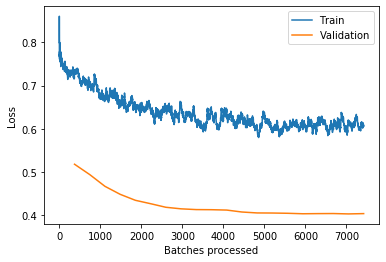

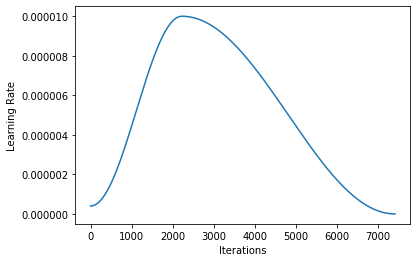

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [0]:
#learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot(suggestion=True)
learn.fit_one_cycle(10, max_lr=slice(1e-5), callbacks=[SaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,time
0,0.591495,0.403254,0.154001,07:36
1,0.590777,0.401789,0.154338,07:38
2,0.596355,0.402830,0.151311,07:37
3,0.581332,0.399856,0.149966,07:33
4,0.603571,0.397472,0.148621,07:32
5,0.578736,0.398479,0.149966,07:35
6,0.608220,0.397768,0.147613,07:32
7,0.584133,0.396385,0.147613,07:32
8,0.583169,0.396464,0.149630,07:33
9,0.609373,0.397813,0.147949,07:32


Better model found at epoch 0 with valid_loss value: 0.4032541513442993.
Better model found at epoch 1 with valid_loss value: 0.4017893075942993.
Better model found at epoch 3 with valid_loss value: 0.39985591173171997.
Better model found at epoch 4 with valid_loss value: 0.3974718153476715.
Better model found at epoch 7 with valid_loss value: 0.3963852524757385.


In [0]:
#learn.load('bestmodel')
learn.load('efficient_net_b7_v2_unfreeze_best')

Learner(data=ImageDataBunch;

Train: LabelList (11896 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,concrete_cement,concrete_cement,concrete_cement,concrete_cement
Path: /content/drive/My Drive/Satellite data/data_processed/train;

Valid: LabelList (2974 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,concrete_cement,irregular_metal,healthy_metal
Path: /content/drive/My Drive/Satellite data/data_processed/train;

Test: LabelList (7325 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Satellite data/data_processed/train, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (stat

In [0]:
import pandas as pd
data = pd.read_csv("testResults.csv")
tests = data.iloc[:,0].values

df_test = [['id','concrete_cement','healthy_metal','incomplete','irregular_metal','other']]
for i in tests:
  img = open_image('data_processed/test/'+i+'.tif')
  ar = np.array(learn.predict(img)[2])
  temp = [i]
  temp.extend(ar)
  df_test.append(temp)

df_test = pd.DataFrame(df_test)
df_test.to_csv('submission_efficientb7_1.csv', index = False)